In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import seaborn as sns
import missingno as msno
import os, warnings

from scipy.stats import boxcox, yeojohnson
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, PowerTransformer, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_log_error,confusion_matrix
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import time
import shap

## **Prédiction pour la variable SiteEnergyUseWN(kBtu)**

## I- Visualisation des données

In [2]:
#Chargement du jeu de données
df = pd.read_csv('Data_Cleaned.csv')

#Afficher le dataset
print(df.head())

   NumberofBuildings  NumberofFloors  PropertyGFAParking  \
0                1.0            12.0                 0.0   
1                1.0            11.0             15064.0   
2                1.0            41.0            196718.0   
3                1.0            10.0                 0.0   
4                1.0            18.0             62000.0   

   PropertyGFABuilding(s)  ENERGYSTARScore  SiteEnergyUseWN(kBtu)  \
0                 88434.0             60.0              7456910.0   
1                 88502.0             61.0              8664479.0   
2                759392.0             43.0             73937112.0   
3                 61320.0             56.0              6946800.5   
4                113580.0             75.0             14656503.0   

   TotalGHGEmissions  BuildingAge  SteamProportion  ElectricityProportion  \
0             249.98         89.0         0.277302               0.546060   
1             295.86         20.0         0.000000               0.386

In [3]:
# Combien de lignes et de colonnes sont contenus dans df
print('Shape : ' + str(df.shape))

Shape : (1543, 38)


In [4]:
# Affichage du nom des colonnes, du type des colonnes et du nombre de variable par type
print(df.info(verbose=True))
print(df.dtypes.value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1543 entries, 0 to 1542
Data columns (total 38 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   NumberofBuildings                          1543 non-null   float64
 1   NumberofFloors                             1543 non-null   float64
 2   PropertyGFAParking                         1543 non-null   float64
 3   PropertyGFABuilding(s)                     1543 non-null   float64
 4   ENERGYSTARScore                            1543 non-null   float64
 5   SiteEnergyUseWN(kBtu)                      1543 non-null   float64
 6   TotalGHGEmissions                          1543 non-null   float64
 7   BuildingAge                                1543 non-null   float64
 8   SteamProportion                            1543 non-null   float64
 9   ElectricityProportion                      1543 non-null   float64
 10  NaturalGasProportion    

In [5]:
df.describe()

,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUseWN(kBtu),TotalGHGEmissions,BuildingAge,SteamProportion,ElectricityProportion,NaturalGasProportion,LargestPropertyUseTypeGFAProportion,SecondLargestPropertyUseTypeGFAProportion,ThirdLargestPropertyUseTypeGFAProportion
count,1543.000000,1543.000000,1543.000000,1.543000e+03,1543.000000,1.543000e+03,1543.000000,1543.000000,1543.000000,1543.000000,1543.000000,1543.000000,1543.000000,1543.000000
mean,1.225164,4.347838,13830.705120,1.076473e+05,63.355893,8.455270e+06,194.002191,54.322100,0.022584,0.699613,0.273874,0.861325,0.126327,0.023222
std,3.041175,6.817131,43747.147997,2.930837e+05,24.563086,2.280459e+07,780.330309,32.864014,0.094192,0.264834,0.264196,0.312595,0.172106,0.063820
min,1.000000,1.000000,0.000000,3.636000e+03,1.000000,0.000000e+00,-0.800000,1.000000,0.000000,-0.336762,0.000000,0.186469,0.000000,0.000000
25%,1.000000,1.000000,0.000000,2.792050e+04,49.071429,1.322090e+06,20.550000,27.000000,0.000000,0.489953,0.000000,0.672986,0.000000,0.000000
50%,1.000000,2.000000,0.000000,4.606800e+04,66.285714,2.811924e+06,49.900000,50.000000,0.000000,0.705181,0.231882,0.940499,0.000000,0.000000
75%,1.000000,4.000000,0.000000,9.571050e+04,82.000000,7.509929e+06,147.315000,86.000000,0.000000,0.999988,0.489359,1.000000,0.244166,0.000000
max,111.000000,99.000000,512608.000000,9.320156e+06,100.000000,4.716139e+08,16870.980000,116.000000,0.766987,1.000003,1.000000,6.426849,1.452054,0.929094


## II- Préparation des données

### 1) Création de la variable discrète

In [6]:
df['SiteEnergyUseWNDisc'] = pd.qcut(df['SiteEnergyUseWN(kBtu)'], q=10, labels=False)

### 2) X et y

In [7]:
#On sépare X et y
X = df.drop(columns = ['SiteEnergyUseWN(kBtu)','SiteEnergyUseWNDisc', 'TotalGHGEmissions', 'ENERGYSTARScore'])
y = df['SiteEnergyUseWN(kBtu)']

In [8]:
print(X.head())
print(y.head())

   NumberofBuildings  NumberofFloors  PropertyGFAParking  \
0                1.0            12.0                 0.0   
1                1.0            11.0             15064.0   
2                1.0            41.0            196718.0   
3                1.0            10.0                 0.0   
4                1.0            18.0             62000.0   

   PropertyGFABuilding(s)  BuildingAge  SteamProportion  \
0                 88434.0         89.0         0.277302   
1                 88502.0         20.0         0.000000   
2                759392.0         47.0         0.297113   
3                 61320.0         90.0         0.325913   
4                113580.0         36.0         0.000000   

   ElectricityProportion  NaturalGasProportion  \
0               0.546060              0.176638   
1               0.386609              0.613391   
2               0.682307              0.020579   
3               0.407519              0.266567   
4               0.378802          

### 3) Test train split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify= df['SiteEnergyUseWNDisc'],
                                                    random_state=20)

In [10]:
print(f'Nous avons X_train de forme {X_train.shape} et y_train de forme {y_train.shape}  ')
print(f'Nous avons X_test de forme {X_test.shape} et y_test de forme {y_test.shape}  ')

Nous avons X_train de forme (1234, 35) et y_train de forme (1234,)  
Nous avons X_test de forme (309, 35) et y_test de forme (309,)  


In [11]:
X_train

,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),BuildingAge,SteamProportion,ElectricityProportion,NaturalGasProportion,LargestPropertyUseTypeGFAProportion,SecondLargestPropertyUseTypeGFAProportion,...,PrimaryType_Worship Facility,Neighborhood_CENTRAL,Neighborhood_DOWNTOWN,Neighborhood_EAST,Neighborhood_GREATER DUWAMISH,Neighborhood_LAKE UNION,Neighborhood_MAGNOLIA / QUEEN ANNE,Neighborhood_NORTHEAST,Neighborhood_NORTHWEST,Neighborhood_SOUTHWEST
571,1.0,4.0,0.0,80360.0,29.0,0.0,0.637036,0.362964,1.000000,0.000000,...,False,False,False,False,False,False,False,True,False,False
1273,1.0,7.0,0.0,47415.0,27.0,0.0,1.000000,0.000000,0.545903,0.147633,...,False,False,True,False,False,False,False,False,False,False
880,1.0,1.0,0.0,35000.0,52.0,0.0,0.999999,0.000000,1.000000,0.000000,...,False,False,False,False,True,False,False,False,False,False
1463,1.0,4.0,0.0,162157.0,11.0,0.0,0.864507,0.135493,0.546988,0.448491,...,False,False,False,False,True,False,False,False,False,False
240,1.0,4.0,166960.0,100375.0,20.0,0.0,0.710820,0.289180,0.624535,0.261646,...,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,1.0,1.0,0.0,76086.0,43.0,0.0,0.478450,0.521550,1.022659,0.000000,...,False,False,False,False,False,False,True,False,False,False
636,1.0,2.0,22867.0,10925.0,10.0,0.0,0.890824,0.109176,0.265418,0.252723,...,False,False,True,False,False,False,False,False,False,False
792,1.0,3.0,0.0,38148.0,98.0,0.0,0.999999,0.000000,0.992267,0.327540,...,False,False,True,False,False,False,False,False,False,False
773,1.0,3.0,0.0,34545.0,36.0,0.0,1.000000,0.000000,1.000000,0.000000,...,False,False,False,False,False,False,True,False,False,False


In [12]:
y_train

571     7.552875e+05
1273    1.552851e+06
880     3.787144e+05
1463    4.122594e+07
240     7.378420e+06
            ...     
143     3.576720e+06
636     2.622096e+06
792     1.262256e+06
773     2.313979e+06
657     9.968500e+05
Name: SiteEnergyUseWN(kBtu), Length: 1234, dtype: float64

## III- Modélisation et évaluation des modèles

In [13]:
def train_and_predict(estimator, X_train, y_train, X_test):
    '''Entraînement et prédiction des modèles'''
    start_time = time.time()
    estimator.fit(X_train, y_train)
    training_time = time.time() - start_time
    y_pred = estimator.predict(X_test)
    return training_time, y_pred

def evaluate_model(y_true, y_pred, model_name, training_time):
    '''évaluation des modèles'''
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"**{model_name}** - R2: {r2:.2f}, RMSE: {rmse:.2f}, MSE: {mse:.2f}, MAE: {mae:.2f}")
    print(f"Training Time ({model_name}): {training_time:.2f} seconds\n")  

### 1) Données sans optimisation

In [14]:
# Dummy Regressor
dummy_estimator = DummyRegressor(strategy='mean')
training_time_dummy, y_pred_dummy = train_and_predict(dummy_estimator, X_train, y_train, X_test)
evaluate_model(y_test, y_pred_dummy, "Dummy Regressor", training_time_dummy)

# Linear Regression
lr_estimator = LinearRegression()
training_time_lr, y_pred_lr = train_and_predict(lr_estimator, X_train, y_train, X_test)
evaluate_model(y_test, y_pred_lr, "Linear Regression", training_time_lr)

# Lasso Regression
lasso_estimator = Lasso()
training_time_lasso, y_pred_lasso = train_and_predict(lasso_estimator, X_train, y_train, X_test)
evaluate_model(y_test, y_pred_lasso, "Lasso", training_time_lasso)

# Ridge Regression
ridge_estimator = Ridge()
training_time_ridge, y_pred_ridge = train_and_predict(ridge_estimator, X_train, y_train, X_test)
evaluate_model(y_test, y_pred_ridge, "Ridge", training_time_ridge)

# ElasticNet Regression
elasticnet_estimator = ElasticNet()
training_time_elasticnet, y_pred_elasticnet = train_and_predict(elasticnet_estimator, X_train, y_train, X_test)
evaluate_model(y_test, y_pred_elasticnet, "ElasticNet", training_time_elasticnet)

# Random Forest Regressor
rf_estimator = RandomForestRegressor()
training_time_rf, y_pred_rf = train_and_predict(rf_estimator, X_train, y_train, X_test)
evaluate_model(y_test, y_pred_rf, "Random Forest Regressor", training_time_rf)

# Gradient Boosting Regressor
gb_estimator = GradientBoostingRegressor()
training_time_gb, y_pred_gb = train_and_predict(gb_estimator, X_train, y_train, X_test)
evaluate_model(y_test, y_pred_gb, "Gradient Boosting Regressor", training_time_gb)

# XGBoost Regressor
xgb_estimator = XGBRegressor()
training_time_xgb, y_pred_xgb = train_and_predict(xgb_estimator, X_train, y_train, X_test)
evaluate_model(y_test, y_pred_xgb, "XGBoost Regressor", training_time_xgb)

**Dummy Regressor** - R2: -0.01, RMSE: 13821745.49, MSE: 191040648488584.97, MAE: 8236382.51
Training Time (Dummy Regressor): 0.00 seconds

**Linear Regression** - R2: 0.08, RMSE: 13233646.97, MSE: 175129412126955.44, MAE: 6168641.79
Training Time (Linear Regression): 0.54 seconds

**Lasso** - R2: 0.08, RMSE: 13233634.56, MSE: 175129083658581.12, MAE: 6168625.45
Training Time (Lasso): 0.08 seconds

**Ridge** - R2: 0.17, RMSE: 12548474.28, MSE: 157464206802387.22, MAE: 5797696.52
Training Time (Ridge): 0.08 seconds

**ElasticNet** - R2: 0.17, RMSE: 12569863.17, MSE: 158001460149881.00, MAE: 5660630.00
Training Time (ElasticNet): 0.00 seconds



Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.618e+15, tolerance: 7.430e+13


**Random Forest Regressor** - R2: 0.51, RMSE: 9606963.92, MSE: 92293755725158.89, MAE: 3511271.62
Training Time (Random Forest Regressor): 2.68 seconds

**Gradient Boosting Regressor** - R2: 0.57, RMSE: 8987283.09, MSE: 80771257303046.88, MAE: 3683998.73
Training Time (Gradient Boosting Regressor): 0.61 seconds

**XGBoost Regressor** - R2: -0.34, RMSE: 15947904.50, MSE: 254335657849209.62, MAE: 4245105.98
Training Time (XGBoost Regressor): 1.02 seconds



### 2) Transformation des variables

In [15]:
colonnes_scaler = X.select_dtypes(['int32', 'float64']).drop(columns=['PropertyGFAParking', 'PropertyGFABuilding(s)']).columns

scaler = StandardScaler()
log_transformer = FunctionTransformer(func=lambda x: np.log10(x + 1))

#Preprocessor
preprocessor = ColumnTransformer([
    ('scaler', scaler, colonnes_scaler),
    ('log_transform', log_transformer, ['PropertyGFAParking', 'PropertyGFABuilding(s)'])
], remainder='passthrough')

#Pipeline
pipeline = Pipeline([
    ('preprocessing', preprocessor)
])

#Transformation des données
X_train_preprocessed = pipeline.fit_transform(X_train)
X_train = pd.DataFrame(X_train_preprocessed, columns=X_train.columns)

X_test_preprocessed = pipeline.transform(X_test)
X_test = pd.DataFrame(X_test_preprocessed, columns=X_test.columns)

In [16]:
# Box-Cox() de la target
transformer = PowerTransformer(method='box-cox', standardize=False)
y_train = transformer.fit_transform(y_train.values.reshape(-1, 1) +1).flatten()
y_test = transformer.transform(y_test.values.reshape(-1, 1)+1).flatten()

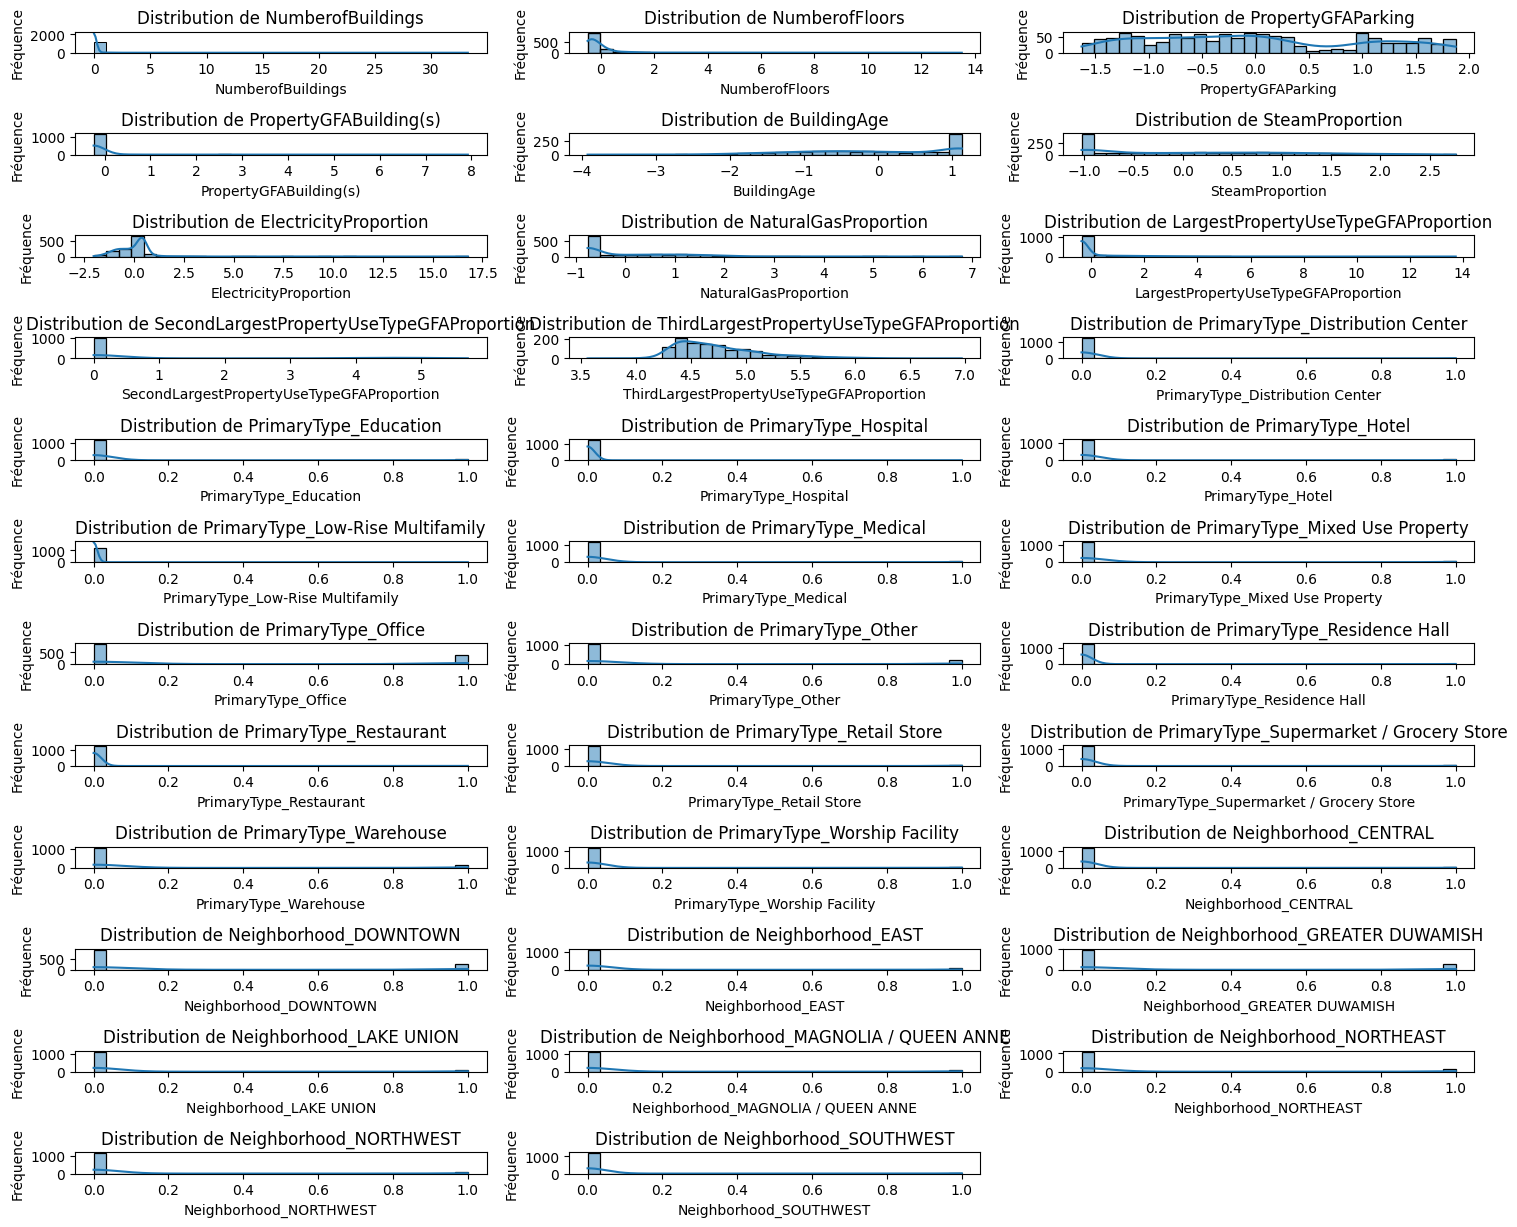

In [17]:
plt.figure(figsize=(15, 15))
for i, colonne in enumerate(X_train):
    plt.subplot(15, 3, i+1)
    sns.histplot(X_train[colonne], kde=True, bins=30)
    plt.title(f'Distribution de {colonne}')
    plt.xlabel(colonne)
    plt.ylabel('Fréquence')
    plt.tight_layout()
plt.show()

In [18]:
# Dummy Regressor
dummy_estimator = DummyRegressor(strategy='mean')
training_time_dummy, y_pred_dummy = train_and_predict(dummy_estimator, X_train, y_train, X_test)
evaluate_model(y_test, y_pred_dummy, "Dummy Regressor", training_time_dummy)

# Linear Regression
lr_estimator = LinearRegression()
training_time_lr, y_pred_lr = train_and_predict(lr_estimator, X_train, y_train, X_test)
evaluate_model(y_test, y_pred_lr, "Linear Regression", training_time_lr)

# Lasso Regression
lasso_estimator = Lasso()
training_time_lasso, y_pred_lasso = train_and_predict(lasso_estimator, X_train, y_train, X_test)
evaluate_model(y_test, y_pred_lasso, "Lasso", training_time_lasso)

# Ridge Regression
ridge_estimator = Ridge()
training_time_ridge, y_pred_ridge = train_and_predict(ridge_estimator, X_train, y_train, X_test)
evaluate_model(y_test, y_pred_ridge, "Ridge", training_time_ridge)

# ElasticNet Regression
elasticnet_estimator = ElasticNet()
training_time_elasticnet, y_pred_elasticnet = train_and_predict(elasticnet_estimator, X_train, y_train, X_test)
evaluate_model(y_test, y_pred_elasticnet, "ElasticNet", training_time_elasticnet)

# Random Forest Regressor
rf_estimator = RandomForestRegressor()
training_time_rf, y_pred_rf = train_and_predict(rf_estimator, X_train, y_train, X_test)
evaluate_model(y_test, y_pred_rf, "Random Forest Regressor", training_time_rf)

# Gradient Boosting Regressor
gb_estimator = GradientBoostingRegressor()
training_time_gb, y_pred_gb = train_and_predict(gb_estimator, X_train, y_train, X_test)
evaluate_model(y_test, y_pred_gb, "Gradient Boosting Regressor", training_time_gb)

# XGBoost Regressor
xgb_estimator = XGBRegressor()
training_time_xgb, y_pred_xgb = train_and_predict(xgb_estimator, X_train, y_train, X_test)
evaluate_model(y_test, y_pred_xgb, "XGBoost Regressor", training_time_xgb)

**Dummy Regressor** - R2: -0.00, RMSE: 9.97, MSE: 99.40, MAE: 7.61
Training Time (Dummy Regressor): 0.00 seconds

**Linear Regression** - R2: 0.63, RMSE: 6.07, MSE: 36.79, MAE: 3.46
Training Time (Linear Regression): 0.00 seconds

**Lasso** - R2: 0.41, RMSE: 7.68, MSE: 58.95, MAE: 5.12
Training Time (Lasso): 0.00 seconds

**Ridge** - R2: 0.63, RMSE: 6.06, MSE: 36.74, MAE: 3.45
Training Time (Ridge): 0.00 seconds

**ElasticNet** - R2: 0.26, RMSE: 8.58, MSE: 73.65, MAE: 6.12
Training Time (ElasticNet): 0.00 seconds

**Random Forest Regressor** - R2: 0.60, RMSE: 6.27, MSE: 39.34, MAE: 3.62
Training Time (Random Forest Regressor): 2.41 seconds

**Gradient Boosting Regressor** - R2: 0.62, RMSE: 6.11, MSE: 37.28, MAE: 3.40
Training Time (Gradient Boosting Regressor): 0.58 seconds

**XGBoost Regressor** - R2: 0.57, RMSE: 6.52, MSE: 42.54, MAE: 3.85
Training Time (XGBoost Regressor): 0.20 seconds



## IV- Optimisation

In [19]:
def resultize(grid):
    '''make a fancy df from grid_.cv_results'''
    res = grid.cv_results_
    res = pd.DataFrame(res)
    cols = [i for i in res.columns if 'split' not in i]
    res = res[cols]
    res = res.sort_values('rank_test_score')
    return res
def grid_search(estimator, param_grid, X_train, y_train):
    '''recherche sur grille'''
    grid = GridSearchCV(estimator,
                        param_grid,
                        cv=5,
                        n_jobs=-1,
                        return_train_score=True,
                        verbose=1)
    grid.fit(X_train, y_train)
    print("Best Score:", grid.best_score_)
    print("Best Params:", grid.best_params_)
    return grid

### 1) Regression linéaire

In [20]:
lr = LinearRegression()

param_grid_lr = {
    'fit_intercept': [True, False],  
    'copy_X': [True, False], 
}

In [21]:
grid_lr = grid_search(lr, param_grid_lr, X_train, y_train)
results_lr = resultize(grid_lr)
lr_estimator = LinearRegression(**grid_lr.best_params_)
training_time_lr, y_pred_lr = train_and_predict(lr_estimator, X_train, y_train, X_test)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Score: 0.4845272302907455
Best Params: {'copy_X': True, 'fit_intercept': True}


In [22]:
pd.set_option('display.max_columns', None)
pd.DataFrame(grid_lr.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_copy_X,param_fit_intercept,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.118765,0.007655,0.000000,0.000000,True,True,"{'copy_X': True, 'fit_intercept': True}",0.577565,0.694384,0.583311,-0.090713,0.658089,0.484527,0.291026,1,0.685764,0.660814,0.686699,0.675225,0.667556,0.675212,0.010092
1,0.081259,0.053590,0.003127,0.006253,True,False,"{'copy_X': True, 'fit_intercept': False}",0.577565,0.694384,0.583311,-0.090713,0.658089,0.484527,0.291026,3,0.685764,0.660814,0.686699,0.675225,0.667556,0.675212,0.010092
2,0.006250,0.007654,0.009374,0.007654,False,True,"{'copy_X': False, 'fit_intercept': True}",0.577565,0.694384,0.583311,-0.090713,0.658089,0.484527,0.291026,1,-56.346589,-57.677941,-62.860606,-52.035589,-58.008666,-57.385878,3.468473
3,0.006249,0.007654,0.003125,0.006250,False,False,"{'copy_X': False, 'fit_intercept': False}",0.577565,0.694384,0.583311,-0.090713,0.658089,0.484527,0.291026,3,0.685764,0.660814,0.686699,0.675225,0.667556,0.675212,0.010092


### 2) Lasso

In [23]:
lasso_estimator = Lasso()

param_grid_lasso = {
    'alpha': [0.1, 1.0, 10.0],  
    'fit_intercept': [True, False], 
}

In [24]:
grid_lasso = grid_search(lasso_estimator, param_grid_lasso, X_train, y_train)
results_lasso = resultize(grid_lasso)
lasso_estimator = Lasso(**grid_lasso.best_params_)
training_time_lasso, y_pred_lasso = train_and_predict(lasso_estimator, X_train, y_train, X_test)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Score: 0.4754778333541356
Best Params: {'alpha': 0.1, 'fit_intercept': True}


### 3) Ridge

In [25]:
ridge_estimator = Ridge()

param_grid_ridge = {
    'alpha': [0.1, 1.0, 10.0],  
    'fit_intercept': [True, False],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag'],
}

In [26]:
grid_ridge = grid_search(ridge_estimator, param_grid_ridge, X_train, y_train)
results_ridge = resultize(grid_ridge)
ridge_estimator = Ridge(**grid_ridge.best_params_)
training_time_ridge, y_pred_ridge = train_and_predict(ridge_estimator, X_train, y_train, X_test)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Score: 0.4844470077308266
Best Params: {'alpha': 0.1, 'fit_intercept': True, 'solver': 'sag'}


### 4) ElasticNet Regression

In [27]:
elasticnet_estimator = ElasticNet()

param_grid_elasticnet = {
    'alpha': [0.1, 1.0, 10.0],  
    'l1_ratio': [0.1, 0.5, 0.9],
    'fit_intercept': [True, False]
}

In [28]:
grid_elasticnet = grid_search(elasticnet_estimator, param_grid_elasticnet, X_train, y_train)
results_elasticnet = resultize(grid_elasticnet)
elasticnet_estimator = ElasticNet(**grid_elasticnet.best_params_)
training_time_elasticnet, y_pred_elasticnet = train_and_predict(elasticnet_estimator, X_train, y_train, X_test)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Score: 0.45957406528539824
Best Params: {'alpha': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9}


### 5) Random Forest Regressor

In [29]:
rf_estimator = RandomForestRegressor()

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3,7,13]
}

In [30]:
grid_rf = grid_search(rf_estimator, param_grid_rf, X_train, y_train)
results_rf = resultize(grid_rf)
rf_estimator = RandomForestRegressor(**grid_rf.best_params_)
training_time_rf, y_pred_rf = train_and_predict(rf_estimator, X_train, y_train, X_test)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Score: 0.5928956267995243
Best Params: {'max_depth': 13, 'n_estimators': 200}


### 6) Gradient Boosting Regressor

In [31]:
gb_estimator = GradientBoostingRegressor()

param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3,7,13],
    'learning_rate': [0.01, 0.1, 0.2]
}

In [32]:
grid_gb = grid_search(gb_estimator, param_grid_gb, X_train, y_train)
results_gb = resultize(grid_gb)
gb_estimator = GradientBoostingRegressor(**grid_gb.best_params_)
training_time_gb, y_pred_gb = train_and_predict(gb_estimator, X_train, y_train, X_test)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Score: 0.6324434219279803
Best Params: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}


### 7) XGBoost Regressor

In [33]:
xgb_estimator = XGBRegressor()

param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3,7,13],
    'learning_rate': [0.01, 0.1, 0.2]
}

In [34]:
grid_xgb = grid_search(xgb_estimator, param_grid_xgb, X_train, y_train)
results_xgb = resultize(grid_xgb)
xgb_estimator = XGBRegressor(**grid_xgb.best_params_)
training_time_xgb, y_pred_xgb = train_and_predict(xgb_estimator, X_train, y_train, X_test)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Score: 0.6565681767845659
Best Params: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}


### 8) Evaluation des modèles

In [35]:
# Linear Regression
evaluate_model(y_test, y_pred_lr, "Linear Regression", training_time_lr)

# Lasso Regression
evaluate_model(y_test, y_pred_lasso, "Lasso", training_time_lasso)

# Ridge Regression
evaluate_model(y_test, y_pred_ridge, "Ridge", training_time_ridge)

# ElasticNet Regression
evaluate_model(y_test, y_pred_elasticnet, "ElasticNet", training_time_elasticnet)

# Random Forest Regressor
evaluate_model(y_test, y_pred_rf, "Random Forest Regressor", training_time_rf)

# Gradient Boosting Regressor
evaluate_model(y_test, y_pred_gb, "Gradient Boosting Regressor", training_time_gb)

# XGBoost Regressor
evaluate_model(y_test, y_pred_xgb, "XGBoost Regressor", training_time_xgb)

**Linear Regression** - R2: 0.63, RMSE: 6.07, MSE: 36.79, MAE: 3.46
Training Time (Linear Regression): 0.00 seconds

**Lasso** - R2: 0.60, RMSE: 6.30, MSE: 39.72, MAE: 3.55
Training Time (Lasso): 0.00 seconds

**Ridge** - R2: 0.63, RMSE: 6.06, MSE: 36.77, MAE: 3.45
Training Time (Ridge): 0.23 seconds

**ElasticNet** - R2: 0.59, RMSE: 6.37, MSE: 40.62, MAE: 3.64
Training Time (ElasticNet): 0.00 seconds

**Random Forest Regressor** - R2: 0.61, RMSE: 6.26, MSE: 39.20, MAE: 3.60
Training Time (Random Forest Regressor): 3.76 seconds

**Gradient Boosting Regressor** - R2: 0.60, RMSE: 6.27, MSE: 39.31, MAE: 3.46
Training Time (Gradient Boosting Regressor): 0.60 seconds

**XGBoost Regressor** - R2: 0.59, RMSE: 6.35, MSE: 40.27, MAE: 3.64
Training Time (XGBoost Regressor): 0.25 seconds



Sur la base du best_score obtenu avec GridSearch, le modèle **XGBoost Regressor** est le meilleur choix.

## V- Impact de L'ENERGYStarScore

In [36]:
X_ESS = df.drop(columns = ['SiteEnergyUseWN(kBtu)','SiteEnergyUseWNDisc', 'TotalGHGEmissions'])
y_ESS = df['SiteEnergyUseWN(kBtu)']

In [37]:
X_train_ESS, X_test_ESS, y_train_ESS, y_test_ESS = train_test_split(X_ESS,
                                                    y_ESS,
                                                    test_size=0.2,
                                                    stratify= df['SiteEnergyUseWNDisc'],
                                                    random_state=20)

In [38]:
colonnes_scaler = X_ESS.select_dtypes(['int32', 'float64']).drop(columns=['PropertyGFAParking', 'PropertyGFABuilding(s)']).columns

scaler = StandardScaler()
log_transformer = FunctionTransformer(func=lambda x: np.log10(x + 1))

#Preprocessor
preprocessor = ColumnTransformer([
    ('scaler', scaler, colonnes_scaler),
    ('log_transform', log_transformer, ['PropertyGFAParking', 'PropertyGFABuilding(s)'])
], remainder='passthrough')

#Pipeline
pipeline = Pipeline([
    ('preprocessing', preprocessor)
])

#Transformation des données
X_train_preprocessed_ESS = pipeline.fit_transform(X_train_ESS)
X_train_ESS = pd.DataFrame(X_train_preprocessed_ESS, columns=X_train_ESS.columns)

X_test_preprocessed_ESS = pipeline.transform(X_test_ESS)
X_test_ESS = pd.DataFrame(X_test_preprocessed_ESS, columns=X_test_ESS.columns)

In [39]:
# Box-Cox() de la target
transformer = PowerTransformer(method='box-cox', standardize=False)
y_train_ESS = transformer.fit_transform(y_train_ESS.values.reshape(-1, 1) +1).flatten()
y_test_ESS = transformer.transform(y_test_ESS.values.reshape(-1, 1)+1).flatten()

In [40]:
xgb_estimator = XGBRegressor()

param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3,7,13],
    'learning_rate': [0.01, 0.1, 0.2]
}

In [41]:
grid_xgb = grid_search(xgb_estimator, param_grid_xgb, X_train_ESS, y_train_ESS)
results_xgb = resultize(grid_xgb)
xgb_estimator = XGBRegressor(**grid_xgb.best_params_)
training_time_xgb_ESS, y_pred_xgb_ESS = train_and_predict(xgb_estimator, X_train_ESS, y_train_ESS, X_test_ESS)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Score: 0.6902230552119618
Best Params: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}


In [42]:
# Gradient Boosting Regressor
evaluate_model(y_test_ESS, y_pred_xgb_ESS, "XGBoost Regressor", training_time_xgb_ESS)

**XGBoost Regressor** - R2: 0.59, RMSE: 6.37, MSE: 40.53, MAE: 3.36
Training Time (XGBoost Regressor): 0.11 seconds



La modèle avec l'EnergyStarScore offre de meilleures performances que le modèle de base. On continue l'étude avec le modèle intégrant l'EnergyStarScore.

## VI- Impact des features sur le modèle

### 1) Feature importance

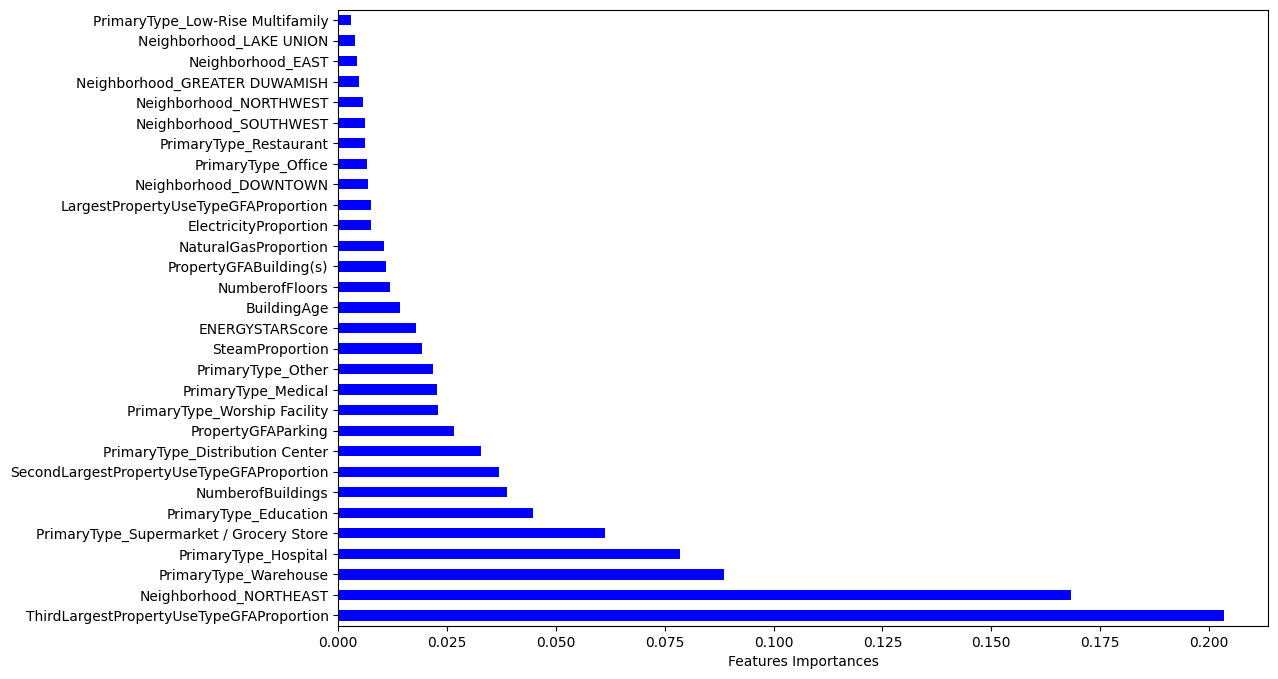

In [43]:
features_importances = pd.Series(xgb_estimator.feature_importances_, index = X_train_ESS.columns)
plt.figure(figsize=(12,8))
features_importances.nlargest(30).plot(kind='barh', color='b')

plt.xlabel('Features Importances')
plt.show()

In [44]:
features_importances.sort_values(ascending=False)

ThirdLargestPropertyUseTypeGFAProportion     0.203416
Neighborhood_NORTHEAST                       0.168321
PrimaryType_Warehouse                        0.088593
PrimaryType_Hospital                         0.078419
PrimaryType_Supermarket / Grocery Store      0.061273
PrimaryType_Education                        0.044767
NumberofBuildings                            0.038756
SecondLargestPropertyUseTypeGFAProportion    0.036867
PrimaryType_Distribution Center              0.032888
PropertyGFAParking                           0.026531
PrimaryType_Worship Facility                 0.022883
PrimaryType_Medical                          0.022657
PrimaryType_Other                            0.021811
SteamProportion                              0.019179
ENERGYSTARScore                              0.017818
BuildingAge                                  0.014128
NumberofFloors                               0.011808
PropertyGFABuilding(s)                       0.010936
NaturalGasProportion        

In [45]:
# Recalcul du modèle en tenant compte des features importance
top_features = features_importances.nlargest(20).index.tolist()
X_train_top_features = X_train_ESS[top_features]
X_test_top_features = X_test_ESS[top_features]

xgb_estimator_top_features = XGBRegressor(**grid_xgb.best_params_)
training_time_xgb_top_features, y_pred_xgb_ESS_top_features = train_and_predict(xgb_estimator_top_features, X_train_top_features, y_train_ESS, X_test_top_features)
evaluate_model(y_test_ESS, y_pred_xgb_ESS_top_features, "XGBoost Regressor with Top Features", training_time_xgb_top_features)

**XGBoost Regressor with Top Features** - R2: 0.60, RMSE: 6.28, MSE: 39.41, MAE: 3.37
Training Time (XGBoost Regressor with Top Features): 0.10 seconds



### 2) SHAP

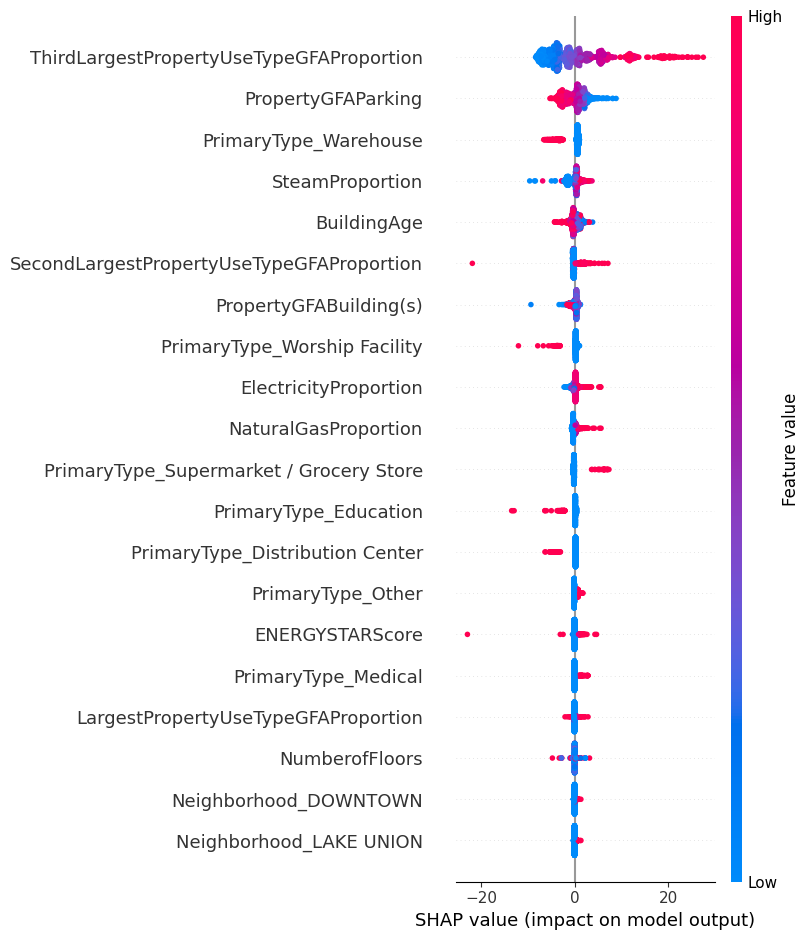

In [52]:
# Calculer les valeurs SHAP
explainer = shap.TreeExplainer(xgb_estimator)
shap_values = explainer.shap_values(X_train_ESS)

# Représentation graphique
plt.figure(figsize=(10, 6))  
shap.summary_plot(shap_values, X_train_ESS, plot_type="dot", show=False)
plt.show()

In [54]:
# Obtenir les valeurs SHAP moyennes par caractéristique
shap_summary_df = pd.DataFrame(shap_values, columns=X_train_ESS.columns)
shap_summary = shap_summary_df.mean()
shap_summary_sorted = shap_summary.sort_values(ascending=False)

print("Valeurs SHAP moyennes par caractéristique :")
print(shap_summary_sorted)

Valeurs SHAP moyennes par caractéristique :
BuildingAge                                  0.084406
PrimaryType_Worship Facility                 0.050228
SecondLargestPropertyUseTypeGFAProportion    0.025696
NumberofFloors                               0.021670
NumberofBuildings                            0.013520
PrimaryType_Other                            0.010513
LargestPropertyUseTypeGFAProportion          0.009787
PropertyGFABuilding(s)                       0.008976
PrimaryType_Office                           0.006454
NaturalGasProportion                         0.004423
ElectricityProportion                        0.002795
Neighborhood_EAST                            0.002319
PrimaryType_Distribution Center              0.002201
Neighborhood_NORTHWEST                       0.002169
Neighborhood_MAGNOLIA / QUEEN ANNE           0.001813
Neighborhood_DOWNTOWN                        0.001582
PrimaryType_Restaurant                       0.001396
PrimaryType_Medical                   

In [48]:
# Sélection des features les plus importantes selon SHAP
top_shap_features = shap_values.mean(0).argsort()[::-1][:20] 
X_train_top_shap_features = X_train_ESS.iloc[:, top_shap_features]
X_test_top_shap_features = X_test_ESS.iloc[:, top_shap_features]

xgb_estimator_top_shap = XGBRegressor(**grid_xgb.best_params_)
training_time_xgb_top_shap, y_pred_xgb_ESS_top_shap = train_and_predict(xgb_estimator_top_shap, X_train_top_shap_features, y_train_ESS, X_test_top_shap_features)
evaluate_model(y_test_ESS, y_pred_xgb_ESS_top_shap, "XGBoost Regressor with Top SHAP Features", training_time_xgb_top_shap)

**XGBoost Regressor with Top SHAP Features** - R2: 0.44, RMSE: 7.47, MSE: 55.73, MAE: 5.07
Training Time (XGBoost Regressor with Top SHAP Features): 0.09 seconds



### Feature Importance du Modèle :
- _**ThirdLargestPropertyUseTypeGFAProportion**_ : Cette caractéristique semble être la plus importante selon cette méthode (0.203416). 
- _**Neighborhood_NORTHEAST**_ : Cette caractéristique est également importante
- _**PrimaryType_Warehouse**_, _**PrimaryType_Hospital**_, _**PrimaryType_Supermarket / Grocery Store**_ : Ces caractéristiques contribuent également à la prédiction, mais elles ont une importance relativement plus faible par rapport à ThirdLargestPropertyUseTypeGFAProportion et Neighborhood_NORTHEAST.
- L'importance de l'_**ENERGYSTARScore**_ est loin derrière avec 0.017818

L'évaluation du modèle tenant compte des 20 features les plus importante selon feature_importance montre des performances similaires au modèle initial en termes de R2, RMSE, MSE et MAE. Cela indique que la sélection de caractéristiques basée sur leur importance n'a pas beaucoup affecté les performances du modèle. On observe cependant que le temps d'entraînement est légèrement plus court avec la réduction des features. Cela peut être dû au fait que la sélection de caractéristiques réduit la dimensionnalité des données, ce qui peut accélérer l'entraînement du modèle.

### SHAP (SHapley Additive exPlanations) :
En se basant sur les valeurs moyennes des caractéristiques :
- _**BuildingAge**_ : Cette caractéristique semble être la plus importante selon cette méthode (0.084406).
- _**PrimaryType_Worship Facility**_, _**SecondLargestPropertyUseTypeGFAProportion**_, _**NumberofFloors**_ : Ces caractéristiques ont également un impact sur la prédiction, mais d'un ordre beaucoup plus faible.

L'évaluation du modèle en tenant compte des features importantes selon SHAP a montré une baisse significative de R2 (0.44 contre 0.59 pour les deux autres modèles), ce qui indique une moins bonne adéquation aux données de test. De plus, le RMSE, MSE et MAE sont tous plus élevés dans ce modèle, indiquant des erreurs de prédiction plus importantes. Cela suggère que la sélection des caractéristiques basée sur SHAP n'a pas réussi à capturer les informations essentielles pour la prédiction, ce qui a conduit à une performance inférieure du modèle.

### Conclusion :
L'ordre et l'importance relative des caractéristiques importantes peuvent varier en fonction de la méthode utilisée. La méthode SHAP fournit une explication plus détaillée en attribuant des valeurs spécifiques à chaque caractéristique pour chaque prédiction, tandis que la feature importance du modèle fournit une vue plus globale basée sur la performance globale du modèle sur l'ensemble des données d'entraînement.
Cependant, la sélection de caractéristiques basée sur SHAP a conduit à une baisse significative des performances du modèle par rapport aux deux autres approches.